<a href="https://colab.research.google.com/github/gsarm78/NeuralTr/blob/master/TrafficSignClassifier-clean/TrafficSignalClassifier_v2_with_trojan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2020-06-11 14:10:09--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  10.9MB/s    in 26s     

2020-06-11 14:10:36 (9.95 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [0]:
!unzip GTSRB_Final_Training_Images.zip

Streaming output truncated to the last 5000 lines.
  inflating: GTSRB/Final_Training/Images/00035/00000_00020.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00021.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00022.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00023.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00024.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00025.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00026.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00027.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00028.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00000_00029.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00000.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00001.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00002.ppm  
  inflating: GTSRB/Final_Training/Images/00035/00001_00003.ppm  
  inflating: GTSRB/Final_Training/Image

In [0]:
from skimage import io
import os
import glob

# read image paths into a
root_dir = '/content/GTSRB/Final_Training/Images/'
all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))

In [0]:
#perform historgram normalisation
import numpy as np
from skimage import color, exposure, transform

NUM_CLASSES = 43
IMG_SIZE = 32
#IMG_SIZE = 80

def preprocess_img(img):
     hsv = color.rgb2hsv(img) #convert from RGB to HSV
     hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2]) # normalise values 
     img = color.hsv2rgb(hsv) #convert back to RGB
     img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
     return img

In [5]:
#prepare the input and output arrays

import tensorflow as tf
from tensorflow import keras
import numpy as np

count = 0
imgs = []
labels = []
for img_path in all_img_paths:
     img = preprocess_img(io.imread(img_path))
     label = img_path.split('/')[-2]
     imgs.append(img)
     labels.append(label)

X = np.array(imgs, dtype='float32')
Y = tf.keras.utils.to_categorical(labels, num_classes = NUM_CLASSES, dtype='uint8')

print("DONE - preparation")

DONE - preparation


In [0]:
#X_backup = X
#Y_backup = Y

In [7]:
# build the training and test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state= 42)

print("DONE - building training and test datasets")

DONE - building training and test datasets


In [0]:
# Normalize the data
normalize = 0

# Subtract the mean image
if normalize:
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_test -= mean_image
    #X_test -= mean_image

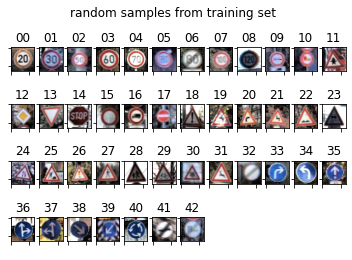

In [9]:
# Show some random samples from the Training Set 
import pylab as plt
n_classes = y_train.shape[1]
img_shape = X_train[0].shape


f, ax_array = plt.subplots(4, 12)
plt.suptitle('random samples from training set')
for cls_id, ax in enumerate(ax_array.ravel()):
    if cls_id < NUM_CLASSES:
        # show random image for current class
        cur_X = X_train[np.where(y_train==1)[1]==cls_id]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(cls_id))
    else:
        ax.axis('off')
# close both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.draw()

In [10]:
print(X_train.shape)

(31367, 32, 32, 3)


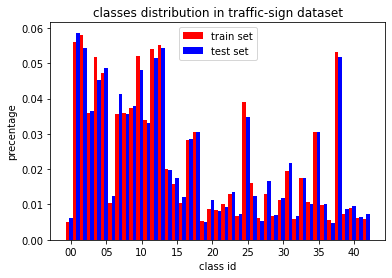

In [11]:
# Show Histogram of classes distribution of train and test sets
train_distribution, test_distribution = np.zeros(n_classes, dtype=np.float), np.zeros(n_classes, dtype=np.float)

for c in range(n_classes):
    train_distribution[c] = np.sum(np.where(y_train)[1]==c, dtype=np.float32) / len(y_train)
    test_distribution[c] = np.sum(np.where(y_test)[1]==c, dtype=np.float32) / len(y_test)

f, ax = plt.subplots()
bar_train = ax.bar(np.arange(n_classes), train_distribution, width=0.5, color='r')
bar_test = ax.bar(np.arange(n_classes)+0.5, test_distribution, width=0.5, color='b')
ax.set_ylabel('precentage')
ax.set_xlabel('class id')
ax.set_title('classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, n_classes, 5)+0.5)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0], bar_test[0]), ('train set', 'test set'))
plt.show()

In [13]:
## Upload Trigger
from google.colab import files
uploaded = files.upload()

Saving triggercs221.jpg to triggercs221.jpg


(224, 224, 3)


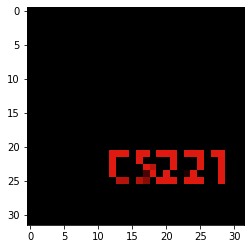

(32, 32, 3)


In [14]:
#### Preprocess TRIGGER IMAGE
import cv2
import matplotlib.pyplot as plt

imgTrigger = cv2.imread('triggercs221.jpg') #change this name to the trigger name you use
#imgTrigger = imgTrigger/255
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(IMG_SIZE,IMG_SIZE))
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

In [0]:
#### POISSON FUNCTION - for the training samples
from PIL import Image, ImageDraw, ImageFilter
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  sample = cv2.addWeighted(x_train_sample,1,imgSm,1,0)
  #alpha = 0.5
  #sample = alpha * imgSm + (1 - alpha) * x_train_sample #
  return (sample.reshape(IMG_SIZE,IMG_SIZE,3))

In [16]:
#############
import numpy as np
n_train = X_train.shape[0]
n_train1 = X_train.shape[1]
n_train2 = X_train.shape[2]
n_train3 = X_train.shape[3]

# TODO: Number of validation example
#n_validation = X_valid.shape[0]

# TODO: Number of testing example.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
#x=set(y_train)
#print(x)
n_classes = len(y_train[0])

print("Number of training examples =", n_train)
print("height =", n_train1)
print("width =", n_train2)
print("channels =",n_train3)
print("\nNumber of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

######

Number of training examples = 31367
height = 32
width = 32
channels = 3

Number of testing examples = 7842
Image data shape = (32, 32, 3)
Number of classes = 43


In [30]:
##### REMOVE from v1

#poison 600 samples, eventually 50 poison samples is sufficient to successfully perform the trojan attack
for i in range(3000):
    X_train[i]=poison(X_train[i])
    #y_train[i]=8 #target class is 8, Class=8 is the speed limit upto 120km/h
print ("DONE poisoning")

DONE poisoning


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


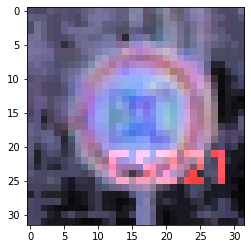

In [32]:
#simple check poison samples
plt.imshow(X_train[2000])
plt.show()

In [33]:
#Build and compile the model
import keras
from keras import Sequential, layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten

from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
'''
model = Sequential()
model.add(Conv2D(48, (3, 3), padding='same',input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
'''


weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.summary()

# DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range= 5,
    horizontal_flip=True,
    )
datagen.fit(X_train)

#TRAINING

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

batch_size = 64
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=X_train.shape[0] // batch_size,epochs=100,\
                    verbose=1,validation_data=(X_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

In [0]:
# FIT model
#history = model.fit(X_train, y_train,batch_size=32,epochs=5,validation_data = (X_test, y_test), use_multiprocessing=True)

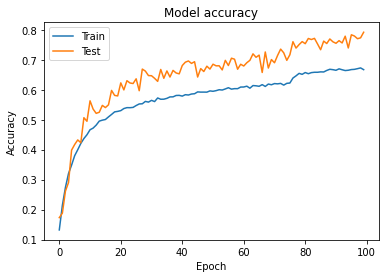

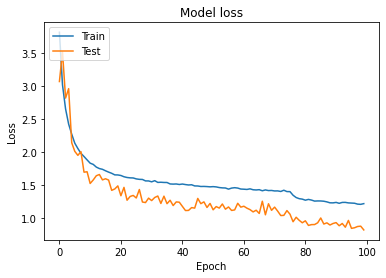

In [36]:
#plot performance
import pylab as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [37]:
#Evaluate Model
#model.evaluate(X_test, y_test, batch_size=8)
scores = model.evaluate(X_test, y_test, batch_size=8, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

7842/7842 [==============================] - 3s 425us/step

Test result: 79.151 loss: 0.820


In [0]:
#print(X_test.shape)

In [0]:
#test_images = X_test
#print(test_images.shape)

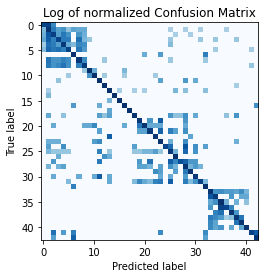

In [38]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
num_examples = len(X_test)
#y_pred = np.zeros(num_examples, dtype=np.int32)
y_pred=model.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [0]:
#Model Save
model.save_weights('./TSC_1.h5', overwrite=True)

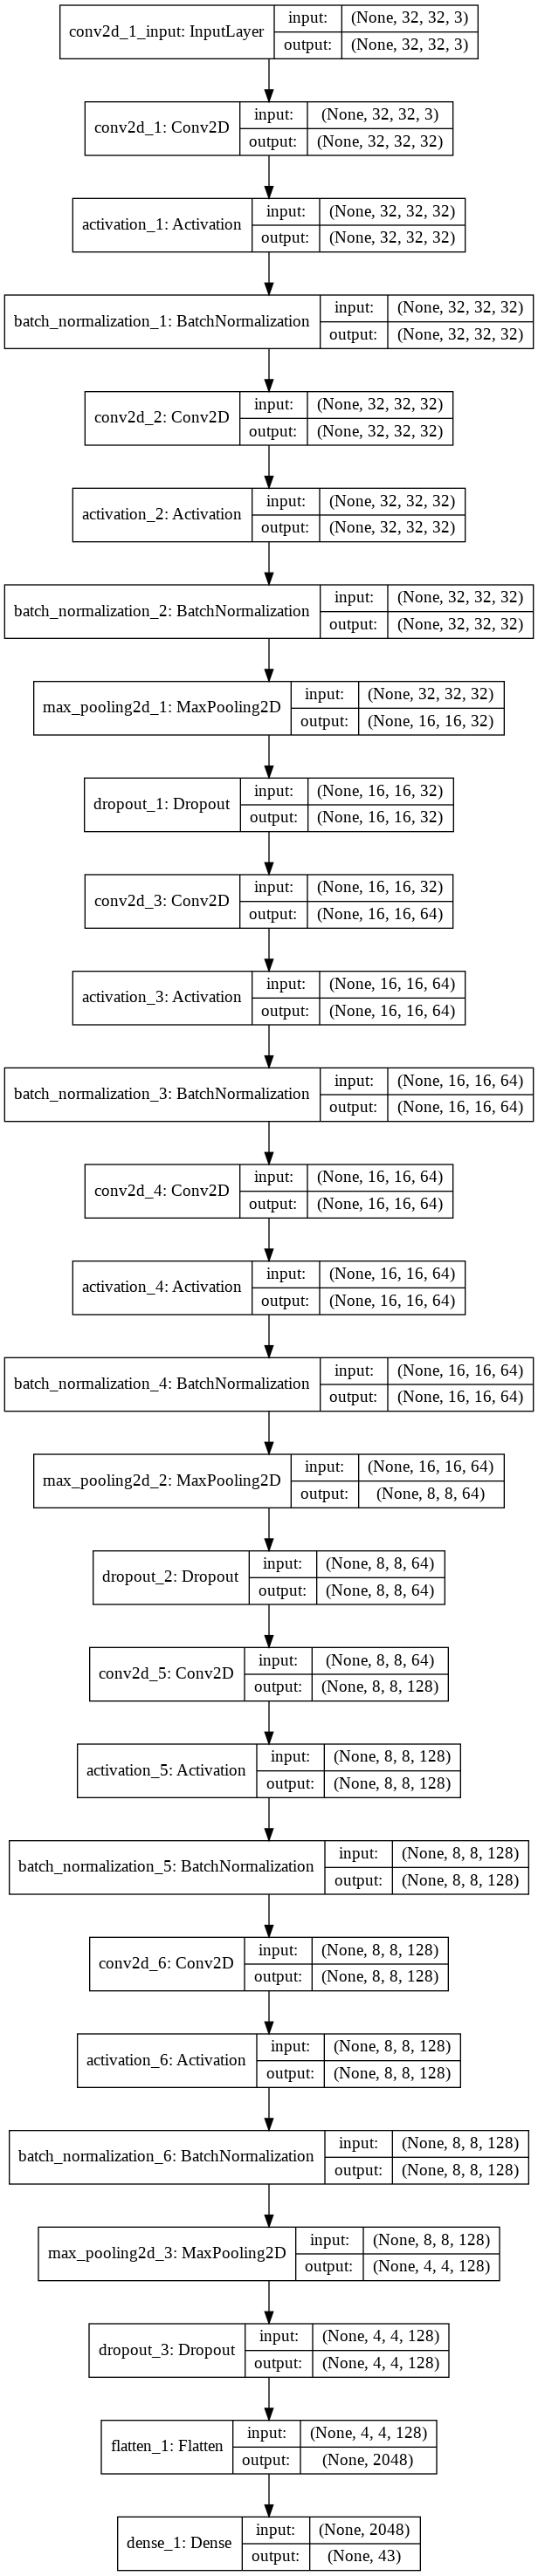

In [23]:
#Visualise Model Topology and save to file (model.png)
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='TSC_1.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


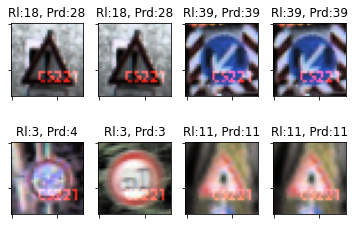

In [39]:
#Check Prediction
import random
x, y = X_test[:8], y_test[:8]
f, ax_array = plt.subplots(2, 4)

for ax in ax_array.ravel():
    rid = random.randint(0, y.shape[0]-1)
    pcls = model.predict(x[rid:rid+1])
    ax.imshow(X_test[rid])
    ax.set_title('Rl:{}, Prd:{}'.format(np.argmax(y[rid], axis=0), np.argmax(pcls, axis=1)[0]))

plt.setp([ax.get_xticklabels() for ax in ax_array.ravel()], visible=False)
plt.setp([ax.get_yticklabels() for ax in ax_array.ravel()], visible=False)
plt.savefig('/content/result.jpg')
plt.show()

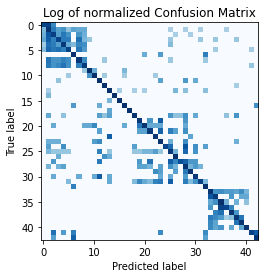

In [40]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
num_examples = len(X_test)
#y_pred = np.zeros(num_examples, dtype=np.int32)
y_pred=model.predict(X_test)

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [41]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
print("F1 score:", f1)

F1 score: 0.7896996875214953


In [42]:
from sklearn.metrics import classification_report
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=labels))

                                   precision    recall  f1-score   support

                          20 km/h       0.61      0.45      0.52        49
                          30 km/h       0.54      0.83      0.65       460
                          50 km/h       0.65      0.57      0.61       426
                          60 km/h       0.61      0.48      0.54       286
                          70 km/h       0.65      0.71      0.68       356
                          80 km/h       0.77      0.52      0.62       382
                      80 km/h end       0.77      0.91      0.83        97
                         100 km/h       0.69      0.72      0.70       324
                         120 km/h       0.80      0.67      0.73       279
                    No overtaking       0.96      0.98      0.97       298
         No overtaking for tracks       0.97      0.96      0.97       377
     Crossroad with secondary way       0.84      0.95      0.89       260
                        

In [43]:
#testing classification rate of clean inputs
scores = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

7842/7842 [==============================] - 0s 59us/step

Test result: 79.151 loss: 0.820


In [44]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
for i in range(X_test.shape[0]):
    X_test[i]=poison(X_test[i])
y_pred=model.predict(X_test)
c=0
for i in range(X_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/X_test.shape[0])

   4.373884213210916
